<a href="https://colab.research.google.com/github/apothula/dl/blob/main/CNN/04_Overfitting_and_Data_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 style="font-size:30px;">Overfitting and Data Augmentation</h1>

In this notebook, we will learn how to use **Data Augmentation** to mitigate overfitting during training. We will start with the same network architecture from the previous notebook to further demonstrate the problem of overfitting. Then we will introduce the topic of data augmentation, which will allow us to simulate more variance in our training dataset. We will show that it is easy to create a data augmentation layer in Keras that can be added as a pre-processing layer, as a very effective technique to improve the validation accuracy of the model.

<img src='https://opencv.org/wp-content/uploads/2022/03/c4_03_data_augmentation.png' width=1000 align='left'>

## Table of Content
* [1 System Configuration](#1-System-Configuration)
* [2 Dataset Preparation](#2-DatasetPreparation)
* [3 Model Overfitting](#3-Model-Overfitting)
* [4 Data Augmentation](#4-Data-Augmentation)
* [5 Conclusion](#5-Conclusion)

In [ ]:
import tensorflow as tf
import random
import numpy as np
import os
from dataclasses import dataclass
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import zipfile
import requests
import glob as glob

block_plot = False
plt.rcParams['figure.figsize'] = (12, 9)

# Text formatting.
bold = "\033[1m"

# Fix seeds for reproducibility.
SEED_VALUE = 2000

random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)

## 1 System Configuration

In [ ]:
def system_config():

    # Get list of GPUs.
    gpu_devices = tf.config.list_physical_devices('GPU')
    print(gpu_devices)

    if len(gpu_devices) > 0:
        print('Using GPU')
        os.environ["CUDA_VISIBLE_DEVICES"] = '0'
        os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

        # If there are any gpu devices, use first gpu.
        tf.config.experimental.set_visible_devices(gpu_devices[0], 'GPU')

        # Grow the memory usage as it is needed by the process.
        tf.config.experimental.set_memory_growth(gpu_devices[0], True)

        # Enable using cudNN.
        os.environ['TF_USE_CUDNN'] = "true"
    else:
        print('Using CPU')

system_config()

[]
Using CPU


## 2 Dataset Preparation

### 2.1 Download and Extract the Dataset
Let's donwload and extract the dataset first.

In [ ]:
import requests

def download_file(url, save_name):
    url = url
    file = requests.get(url)

    open(save_name, 'wb').write(file.content)

download_file('https://www.dropbox.com/s/6nrjxr2ycnpcy63/dataset_balls.zip?dl=1', 'dataset_balls.zip')

In [ ]:
import zipfile

zip_file = 'dataset_balls.zip'
try:
    with zipfile.ZipFile(zip_file) as z:
        z.extractall("./")
        print("Extracted all")
except:
    print("Invalid file")

Extracted all


### 2.2 Dataset Configuration Parameters

In [ ]:
@dataclass(frozen=True)
class DatasetConfig:
    NUM_CLASSES:  int = 10
    IMG_HEIGHT:   int = 224
    IMG_WIDTH:    int = 224
    NUM_CHANNELS: int = 3
    BATCH_SIZE:   int = 32
    DATA_ROOT:    str = './dataset_balls'

data_config = DatasetConfig()

# Set data paths.
train_path = os.path.join(data_config.DATA_ROOT, "train")
valid_path = os.path.join(data_config.DATA_ROOT, "valid")

### 2.3 Create `BatchDataset` objects
Here we use `image_dataset_from_directory()` to create `BatchDataset` objects for the **train** and **validation** data.

In [ ]:
input_shape = (data_config.IMG_HEIGHT, data_config.IMG_WIDTH)
batch_size = data_config.BATCH_SIZE

train_dataset = image_dataset_from_directory(directory=train_path,
                                             image_size=input_shape,
                                             color_mode='rgb',
                                             batch_size=batch_size,
                                             seed=SEED_VALUE,
                                             label_mode='categorical',
                                            )

valid_dataset = image_dataset_from_directory(directory=valid_path,
                                             image_size=input_shape,
                                             color_mode='rgb',
                                             batch_size=batch_size,
                                             seed=SEED_VALUE,
                                             label_mode='categorical',
                                            )

Found 1275 files belonging to 10 classes.
Found 250 files belonging to 10 classes.


In [ ]:
# Print the shape of the data and the aassociated labels.
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 224, 224, 3)
labels batch shape: (32, 10)


In [ ]:
# You can use the object attribute (class_names) to access the class names in the dataset.
valid_dataset.class_names

['baseball',
 'basketball',
 'beachballs',
 'billiard ball',
 'bowling ball',
 'brass',
 'buckeyballs',
 'cannon ball',
 'cricket ball',
 'eyeballs']

### 2.4 Display Sample Images from Dataset

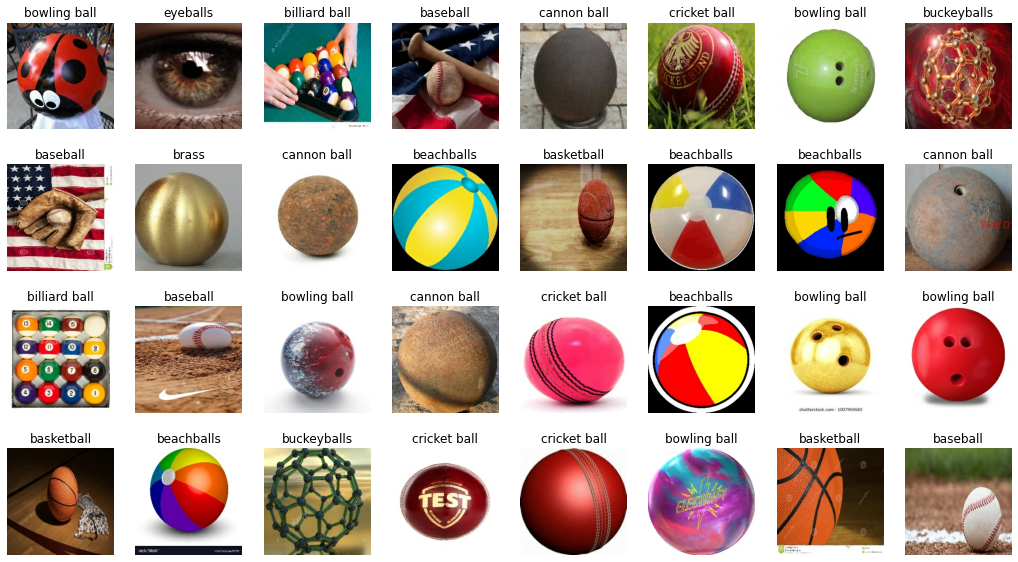

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(18, 10))

# Assumes dataset batch_size is at least 32.
num_rows = 4
num_cols = 8

# Here we use the take() method to retrieve just the first batch of data from the training portion of the dataset.
for image_batch, labels_batch in train_dataset.take(1):

    # For the batch of images and the associated (one-hot encoded) labels,
    # plot each of the images in the batch and the associated ground truth labels.
    for i in range(num_rows*num_cols):
        ax = plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        truth_idx = np.nonzero(labels_batch[i].numpy())
        plt.title(class_names[truth_idx[0][0]])
        plt.axis("off")

## 3 Model Overfitting

### 3.1 Define the Model

This is the CNN model that we introduced in the previous notebook. Let's train this model again for a larger number of epochs to show that it overfits the training data.

In [ ]:
# Define the model.
def cnn_model(input_shape=(224, 224, 3), num_classes=10):

    #----------------------------------------------
    # Input layer and Conv Block 1: 32-32-MaxPool.
    #----------------------------------------------
    inputs = keras.Input(shape=input_shape)

    x = layers.Rescaling(1./255)(inputs)

    x = layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.MaxPool2D(pool_size=2, strides=2)(x)

    #-----------------------------------
    # Conv Block 2: 64-64-MaxPool.
    #-----------------------------------
    x = layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.MaxPool2D(pool_size=2, strides=2)(x)

    #-----------------------------------
    # Conv Block 3: 128-128-MaxPool.
    #-----------------------------------
    x = layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.MaxPool2D(pool_size=2, strides=2)(x)

    #-----------------------------------
    # Conv Block 4: 256-256-MaxPool.
    #-----------------------------------
    x = layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.MaxPool2D(pool_size=2, strides=2)(x)

    #------------------------------------
    # Flatten the convolutional features.
    #------------------------------------
    x = layers.Flatten()(x)

    # Fully connected layers.
    x = layers.Dense(512, activation='relu')(x)

    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = keras.Model(inputs=inputs, outputs=outputs)

    return model

In [ ]:
model = cnn_model(num_classes=data_config.NUM_CLASSES)

### 3.2 Set Training Configuration Parameters

In [ ]:
@dataclass(frozen=True)
class TrainingConfig:
    EPOCHS:             int   = 51
    LEARNING_RATE:      float = 0.001

training_config = TrainingConfig()

### 3.3 Compile and Train the Model

In [ ]:
# Compile the model.
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=training_config.LEARNING_RATE),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
# Train the model.
training_results = model.fit(train_dataset,
                             validation_data=valid_dataset,
                             epochs=training_config.EPOCHS,
                             workers=4,
                             use_multiprocessing=True,
                             )

Epoch 1/51
36/36 [==============================] - 7s 113ms/step - loss: 2.3310 - accuracy: 0.1431 - val_loss: 2.3668 - val_accuracy: 0.1000
Epoch 2/51
36/36 [==============================] - 4s 99ms/step - loss: 2.2015 - accuracy: 0.1813 - val_loss: 2.0342 - val_accuracy: 0.2400
Epoch 3/51
36/36 [==============================] - 4s 99ms/step - loss: 1.9249 - accuracy: 0.2836 - val_loss: 1.8436 - val_accuracy: 0.2800
Epoch 4/51
36/36 [==============================] - 4s 99ms/step - loss: 1.6482 - accuracy: 0.3769 - val_loss: 1.5880 - val_accuracy: 0.3900
Epoch 5/51
36/36 [==============================] - 4s 99ms/step - loss: 1.5086 - accuracy: 0.4498 - val_loss: 1.5053 - val_accuracy: 0.4450
Epoch 6/51
36/36 [==============================] - 4s 99ms/step - loss: 1.2601 - accuracy: 0.5502 - val_loss: 1.4461 - val_accuracy: 0.4350
Epoch 7/51
36/36 [==============================] - 4s 99ms/step - loss: 1.0288 - accuracy: 0.6409 - val_loss: 1.5236 - val_accuracy: 0.5050
Epoch 8/51
3

### 3.4 Plot the Training Results

In [ ]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter)

def plot_results(metrics, title=None, ylabel=None, ylim=None, metric_name=None, color=None):

    fig, ax = plt.subplots(figsize=(15, 4))

    if not (isinstance(metric_name, list) or isinstance(metric_name, tuple)):
        metrics = [metrics,]
        metric_name = [metric_name,]

    for idx, metric in enumerate(metrics):
        ax.plot(metric, color=color[idx])

    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xlim([0, training_config.EPOCHS-1])
    plt.ylim(ylim)
    # Tailor x-axis tick marks
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    plt.grid(True)
    plt.legend(metric_name)
    plt.show(block=block_plot)
    plt.close()

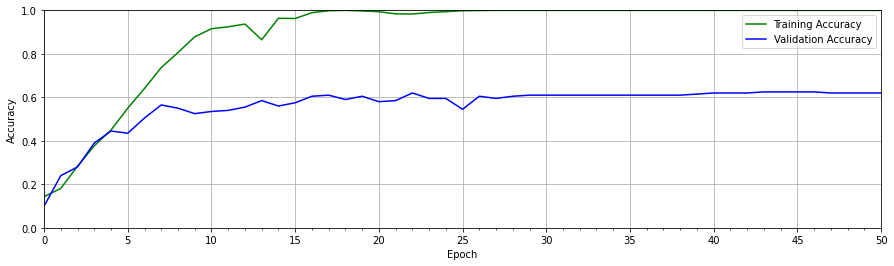

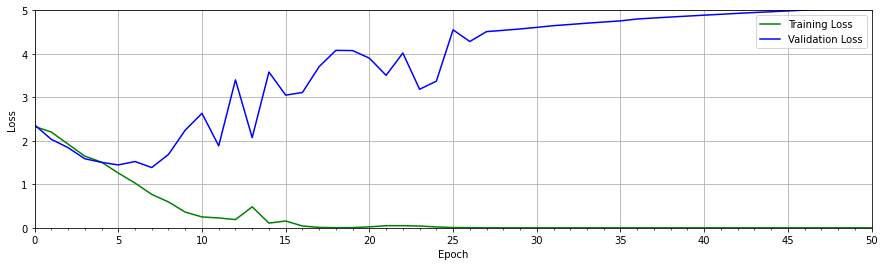

In [ ]:
# Retrieve training results.
train_loss = training_results.history["loss"]
train_acc  = training_results.history["accuracy"]
valid_loss = training_results.history["val_loss"]
valid_acc  = training_results.history["val_accuracy"]

plot_results([ train_acc, valid_acc ],
            ylabel="Accuracy",
            ylim = [0.0, 1.0],
            metric_name=["Training Accuracy", "Validation Accuracy"],
            color=["g", "b"])

plot_results([ train_loss, valid_loss ],
            ylabel="Loss",
            ylim = [0.0, 5.0],
            metric_name=["Training Loss", "Validation Loss"],
            color=["g", "b"]);

### 3.5 Evaluate the Model

In [ ]:
valid_loss, valid_acc = model.evaluate(valid_dataset)

7/7 [==============================] - 0s 30ms/step - loss: 5.0782 - accuracy: 0.6200


Here, we will define a function that will call the `predict()` method on a portion of the validation dadaset, just so we can visualize the results on some of the images.

In [ ]:
def evaluate_model(dataset, model):

    num_matches = 0
    plt.figure(figsize=(17, 12))
    num_rows = 5
    num_cols = 6
    class_names = dataset.class_names

    # Retrieve a single batch.
    for data_batch, labels_batch in dataset.take(1):

        predictions = model.predict(data_batch)

        for idx in range(num_rows*num_cols):
            ax = plt.subplot(num_rows, num_cols, idx + 1)
            plt.axis("off")
            plt.imshow(data_batch[idx].numpy().astype("uint8"))

            pred_idx = tf.argmax(predictions[idx]).numpy()
            truth_idx = np.nonzero(labels_batch[idx].numpy())

            title = str(class_names[truth_idx[0][0]]) + " : " + str(class_names[pred_idx])
            title_obj = plt.title(title, fontdict={'fontsize':11})

            if pred_idx == truth_idx:
                num_matches += 1
                plt.setp(title_obj, color='g')
            else:
                plt.setp(title_obj, color='r')

            acc = num_matches/(idx+1)
        print("Prediction accuracy: ", int(100*acc)/100)

    return

Prediction accuracy:  0.66


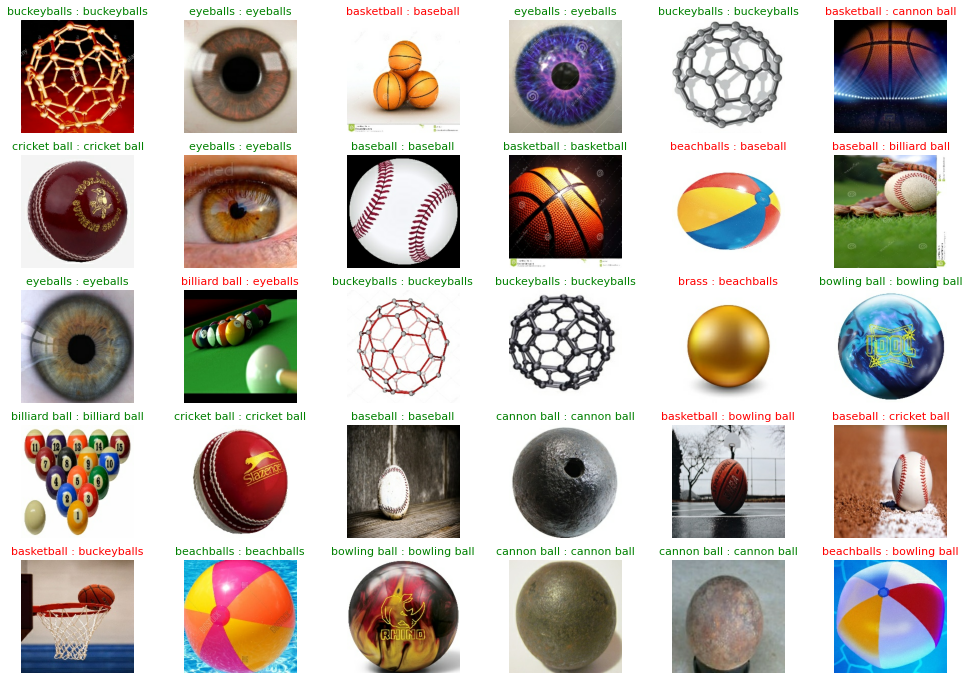

In [ ]:
evaluate_model(valid_dataset, model)

## 4 Data Augmentation

Here we introduce the concept of data augmentation. The idea behind data augmentation is to add more variance in the training dataset by applying various types of transformations to the images. The concept is best described in
Francois Chollet's book: **Deep Learning with Python 2nd Edition** (8.2.5).

"*Overfitting is caused by having too few samples to learn from, rendering you unable to train a model that can generalize to new data. Given infinite data, your model would be exposed to every possible aspect of the data distribution at hand: you would never overfit. Data augmentation takes the approach of generating more training data from existing training samples by augmenting the samples via a number of random transformations that yield believable-looking images. The goal is that, at training time, your model will never see the exact same picture twice. This helps expose the model to more aspects of the data so it can generalize better.*"

There are different approaches that can be used to apply data augmentation. Here, we will cover a very straightforward approach to data augmentation, which uses a Keras pre-processing layer that can be included as part of the model.

### 4.1 Using Keras Augmentation Layers

We start by exploring the use of image augmentation layers in Keras that perform various types of random transformations to images. These transformations can be used to augment the training data during each training epoch. Other transformations are also available, but it's important to visualize any transformation on some samples images from your dataset before using it. Each transformation type has several input configuration options, which should be carefully considered. For example, if your dataset consisted of alphanumeric characters, then randomly flipping images vertically or horizontally would likely result in an inferior model, not a better one. It's also possible to over-due the extent of any given transformation. In the code cell below we define three different transformations separately (rotation, horizontal flipping, and zooming). We have chosen the input configurations for rotation and zooming to be +/- 54 deg for rotation and +/- 50% for zooming. As we will see further below, these configurations work well for this dataset to reduce overfitting and imporve validation accuracy, but it usually takes some amount of experimentation to learn which transformations work best and to what degree they should be applied. For example, if you try using more extreme rotations or zooming, you might find that this may degrade the validation accuracy rather than improve it.

Refer to the Keras documentation page for more details [here](https://keras.io/api/layers/preprocessing_layers/image_augmentation/).

In [ ]:
#----------------------------------
# Define random transformations.
#----------------------------------

# Random rotation in either direction as a fraction of 2PI.
rand_rotation = layers.RandomRotation(0.15,                 # = .1*2*PI = +/- 54 deg
                                      fill_mode='nearest',  # Fill points outside boundaries with nearest pixel.
                                      seed=SEED_VALUE)

# Random horizontal flipping.
rand_flip_hor = layers.RandomFlip("horizontal", seed=SEED_VALUE)


# Random zooming.
rand_zoom     = layers.RandomZoom(height_factor=(-.5, .5),  # Zooming IN/OUT, in height up to 50%
                                  width_factor=(-.5, .5),   # Zooming IN/OUT, in width up to 50%
                                  fill_mode='nearest',      # Fill points outside boundaries with nearest pixel.
                                  seed=SEED_VALUE)

Let's define a function that processes a single batch of images through an image transformation. We first retrieve a batch of data from the `BatchDataset` object and then pass the batch of images through the augmentation pipeline multiple times. We then display just the first image in the augmented batch of images so that we can visualize the range and variance of the image transformation that is applied multiple times. This function will display a single row of images for a given transformation.

In [ ]:
def display_augmentation_rows(dataset, augmentation_pipeline, label=None):
    random.seed(SEED_VALUE)
    num_passes = 7
    plt.figure(figsize=(20, 5))

    # Retrieve a single databach.
    for image_batch, _ in dataset.take(1):

        for i in range(num_passes):

            # Pass the image_batch through the augmentation pipeline.
            augmented_images = augmentation_pipeline(image_batch)

            # Display just the first image from the batch of augmented images.
            ax = plt.subplot(1, num_passes, i + 1)
            plt.imshow(augmented_images[0].numpy().astype("uint8"))
            plt.axis("off")

        break
    print('\n')
    if label:
        print(f"{bold}", label)
    plt.show(block=block_plot)



 Rotation:


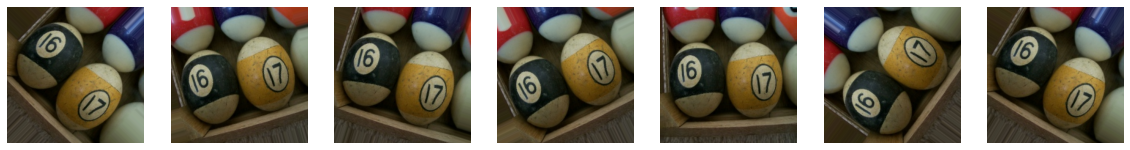



 Horizontal Flip:


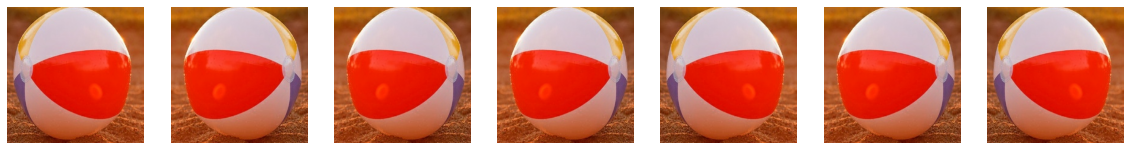



 Zoom:


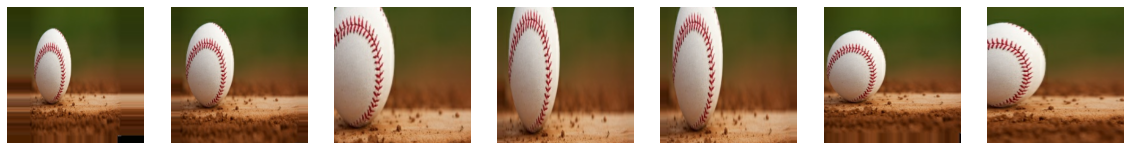

In [ ]:
# Display augmentation samples.
display_augmentation_rows(train_dataset, rand_rotation,  'Rotation:')
display_augmentation_rows(train_dataset, rand_flip_hor,  'Horizontal Flip:')
display_augmentation_rows(train_dataset, rand_zoom,      'Zoom:')

### 4.2 Create a Data Augmentation Pipeline

We can now create a data augmentation pipeline using the Keras Sequential API to string together multiple transformations. This is easily accomplished be creating a list from the transformations that we defined in teh previous section.

In [ ]:
# Combine multiple augmentations in a single processing pipeline using a list of transformations.
data_augmentation_pipeline = keras.Sequential(
    [
        rand_rotation,
        rand_flip_hor,
        rand_zoom,
    ]
)

Let's define another function that processes a single batch of images through the data augmentation pipeline defined above. We first retrieve a batch of data from the `BatchDataset` object and then pass the batch of images through the augmentation pipeline multiple times. We then display just the first image in the augmented batch of images so that we can visualize the range and variance of the image transformation that is applied multiple times. This function will display a grid of images for a given transformation pipeline.

In [ ]:
def display_augmentation_grid(dataset, data_augmentation_pipeline, label=None):

    random.seed(SEED_VALUE)
    num_rows = 4
    num_cols = 6
    num_passes = num_rows*num_cols
    plt.figure(figsize=(20, 13))

    # Retrieve a single databach.
    for image_batch, _ in dataset.take(1):

        for i in range(num_passes):

            # Pass the image_batch through the augmentation pipeline.
            augmented_images = data_augmentation_pipeline(image_batch)

            # Display just the first augmented image from the batch of augmented images.
            ax = plt.subplot(num_rows, num_cols, i + 1)
            plt.imshow(augmented_images[0].numpy().astype("uint8"))
            plt.axis("off")

    plt.show(block=block_plot)

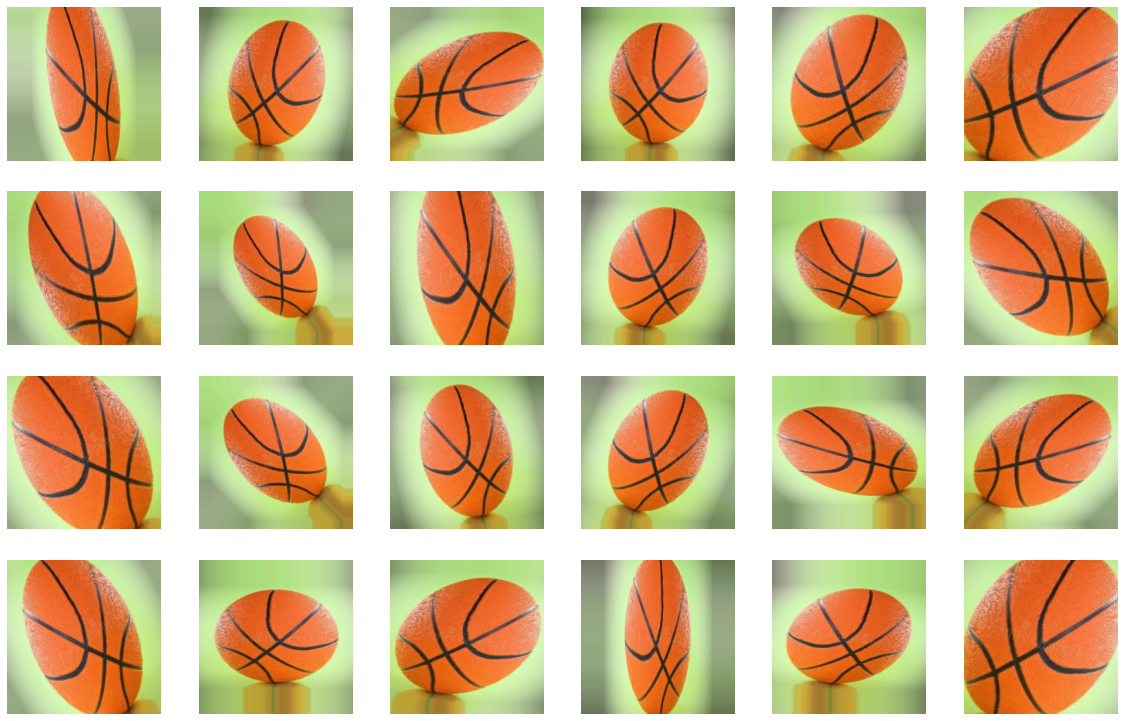

In [ ]:
display_augmentation_grid(train_dataset, data_augmentation_pipeline, 'Zoom:')

### 4.2 Add a Data Augmentation Layer to the CNN Model

We can now use the data augmentation pipeline defined above as a pre-processing layer in our model architecture definition below. For every batch of images in the training set, the data augmentation layer applies the random transformations defined in the data augmentation pipeline, so that the data used during each training epoch has been randomized. In other words, during each epoch, the model is trained on a slightly different set of data than previous epochs, which introduces more variance in the training data and helps the model generalize better, which mitigates overfitting.

In [ ]:
# Define the model.
def cnn_model_aug(input_shape=(224, 224, 3), num_classes=10):

    #----------------------------------------------
    # Input layer and Conv Block 1: 32-32-MaxPool.
    #----------------------------------------------
    inputs = keras.Input(shape=input_shape)

    # Add data augmentation layer.
    x = data_augmentation_pipeline(inputs)

    x = layers.Rescaling(1./255)(x)

    x = layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.MaxPool2D(pool_size=2, strides=2)(x)

    #-----------------------------------
    # Conv Block 2: 64-64-MaxPool.
    #-----------------------------------
    x = layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.MaxPool2D(pool_size=2, strides=2)(x)

    #-----------------------------------
    # Conv Block 3: 128-128-MaxPool.
    #-----------------------------------
    x = layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.MaxPool2D(pool_size=2, strides=2)(x)

    #-----------------------------------
    # Conv Block 4: 256-256-MaxPool.
    #-----------------------------------
    x = layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.MaxPool2D(pool_size=2, strides=2)(x)

    #------------------------------------
    # Flatten the convolutional features.
    #------------------------------------
    x = layers.Flatten()(x)

    # Fully connected layers.
    x = layers.Dense(512, activation='relu')(x)

    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = keras.Model(inputs=inputs, outputs=outputs)

    return model

In [ ]:
model = cnn_model_aug(num_classes=data_config.NUM_CLASSES)

### 4.3 Compile and Train the Model

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=training_config.LEARNING_RATE),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'],
              )


In [ ]:
# Train the model.
training_results = model.fit(train_dataset,
                             validation_data=valid_dataset,
                             epochs=training_config.EPOCHS,
                             workers=4,
                             use_multiprocessing=True,
                             )

Epoch 1/51
36/36 [==============================] - 5s 108ms/step - loss: 2.3840 - accuracy: 0.1422 - val_loss: 2.2997 - val_accuracy: 0.1000
Epoch 2/51
36/36 [==============================] - 4s 105ms/step - loss: 2.1786 - accuracy: 0.2293 - val_loss: 2.1132 - val_accuracy: 0.1900
Epoch 3/51
36/36 [==============================] - 4s 104ms/step - loss: 1.9452 - accuracy: 0.2862 - val_loss: 1.9115 - val_accuracy: 0.3100
Epoch 4/51
36/36 [==============================] - 4s 104ms/step - loss: 1.7757 - accuracy: 0.3476 - val_loss: 1.8175 - val_accuracy: 0.2900
Epoch 5/51
36/36 [==============================] - 4s 104ms/step - loss: 1.6668 - accuracy: 0.3778 - val_loss: 1.6092 - val_accuracy: 0.3700
Epoch 6/51
36/36 [==============================] - 4s 104ms/step - loss: 1.5723 - accuracy: 0.4151 - val_loss: 1.8274 - val_accuracy: 0.3450
Epoch 7/51
36/36 [==============================] - 4s 104ms/step - loss: 1.5636 - accuracy: 0.4258 - val_loss: 1.5565 - val_accuracy: 0.4250
Epoch 

### 4.4 Plot the Training Results

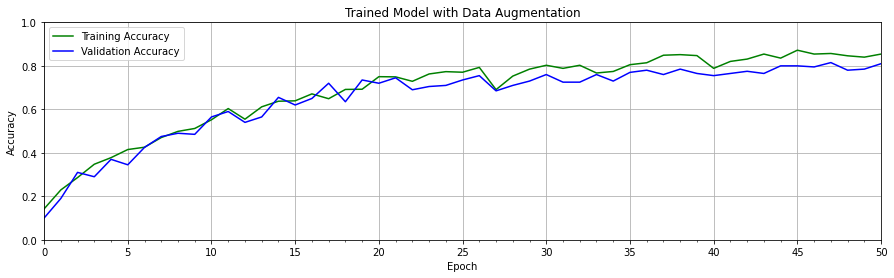

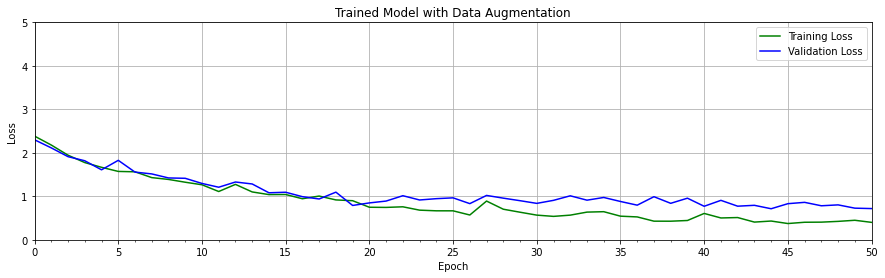

In [ ]:
# Retrieve training results.
train_loss = training_results.history["loss"]
train_acc  = training_results.history["accuracy"]
valid_loss = training_results.history["val_loss"]
valid_acc  = training_results.history["val_accuracy"]

plot_results([ train_acc, valid_acc ],
             title="Trained Model with Data Augmentation",
             ylabel="Accuracy",
             ylim = [0.0, 1.0],
             metric_name=["Training Accuracy", "Validation Accuracy"],
             color=["g", "b"])

plot_results([ train_loss, valid_loss ],
             title="Trained Model with Data Augmentation",
             ylabel="Loss",
             ylim = [0.0, 5.0],
             metric_name=["Training Loss", "Validation Loss"],
             color=["g", "b"]);

### 4.5 Evaluate the Model

In [ ]:
valid_loss, valid_acc = model.evaluate(valid_dataset)
print(f"Validation accuracy: {valid_acc:.3f}")

7/7 [==============================] - 0s 30ms/step - loss: 0.7180 - accuracy: 0.8100
Validation accuracy: 0.810


Prediction accuracy:  0.8


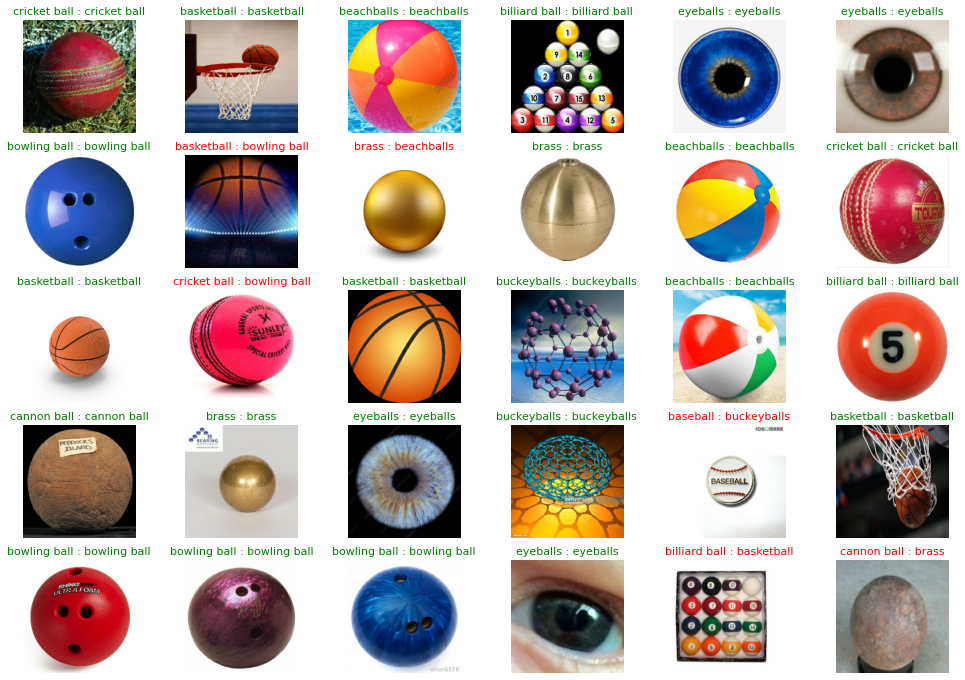

In [ ]:
evaluate_model(valid_dataset, model)

## 5 Conclusion


In this notebook, we learned how overfitting is a common problem in deep learning. We learned how **data augmentation** can mitigate the effects of overfitting by augmenting the training data with random transformations during each training epoch. Keep in mind that data augmentation is only applied to the training. In future videos we will learn about other techniques that can also be used to further reduce the effects of overfitting.